# PARAMETERS

In [1]:
####### CONFIGURATION

class CFG:

    # environment
    environment = 'local'  # work environment ('kaggle', 'colab', 'local')
    device      = 'GPU'    # device ('CPU', 'GPU', 'TPU')
    device_id   = 1        # device id (if multiple GPUs are available)
    num_workers = 4        # no. cores

    # general
    version  = 135    # notebook version (for saving outputs)
    debug    = False  # debug mode runs 5 batches for 2 epochs on 2 folds
    seed     = 13353  # random state

    # data
    num_folds  = 5      # number of CV folds
    data_2019  = True   # append 2019 labeled data to training folds (1a)
    data_pl    = 0.2   # False or percentage of appended pseudo-labeled data (1b)
    data_ext   = False  # False or list with external dataset ids (2, 3, 4, 5)
    drop_dupl  = True   # drop duplicate images from training folds
    drop_outs  = False  # drop outliers from training folds
    oversample = False  # enable oversampling through WeightedRandomSampler()
    
    # label noise
    drop_noise  = False  # False or percentage of removed noisy labels in training folds
    flip_noise  = False  # False or percentage of flipped noisy labels in training folds
    flip_prob   = 0.1    # False or probability of flipping labels in training folds

    # image size and augmentations 
    image_size = 512                # image size after random crop
    crop_scale = (0.1, 1)           # min scale, max scale
    gr_shuffle = (4, 4)             # number of tiles in shuffled grid
    ssr        = [0.05, 0.05, 360]  # shift, scale, rotation limits
    huesat     = [20, 20, 20]       # hue, saturation, value limits
    bricon     = [0.1, 0.1]         # brightness, contrast limits
    blur_limit = 3                  # blur limit
    dist_limit = 0.1                # distortion limit
    cutout     = [5, 0.1]           # number of squares, size of squares
    clahe      = [2.0, 8]           # clip limit, size of grid
    p_augment  = 0.5                # prob. of augmentations except for flips
    cutmix     = [0.1, 1]           # cutmix batch-level probability, alpha
    normalize  = False              # pixel normalization (False, 'dataset', 'imagenet')

    # model architecture
    backbone  = 'tf_efficientnet_b5_ns'  # convolutional backbone
    weights   = 'imagenet'             # weights ('empty', 'imagenet', 'custom')
    save_all  = False                  # save weights from each epoch
    attention = True                   # whether to include attention module (efficientnet only)

    # pretrained model
    pr_version     = 3   # notebook version (2, 3, 4, 5)
    pr_num_classes = 10  # no. classes (2: 4, 3: 10, 4: 2, 5: 17)

    # training
    batch_size  = 32    # no. images per batch
    num_epochs  = 10    # no. epochs per fold
    fine_tune   = 2     # fine-tuning head after training (False or no. epochs)
    accum_iter  = 1     # no. batches for gradient accumalation
    use_amp     = True  # automated mixed precision mode

    # learning rate and optimizer
    eta     = 1e-4    # starting learning rate
    eta_min = 1e-6    # ending learning rate
    optim   = 'Adam'  # LR optimizer ('Adam', 'AdamW', 'AdamP')
    decay   = 1e-6    # weight decay of optimizer (L2 regularization)

    # learning rate scheduler
    warmup          = 1                  # no. epochs for warmup
    warmup_freeze   = False              # freeze deep layers during warmup
    schedule        = 'CosineAnnealing'  # LR scheduler after warmup
    update_on_batch = True               # update LR after every batch or epoch

    # loss function
    loss_fn     = 'Taylor'     # loss function ('CE', 'OHEM', 'SCE', 'CCE', 'Focal', 'FocalCosine', 'Taylor', 'BiTempered')
    smoothing   = 0.2          # label smoothing (works with all losses)
    ohem        = 0.8          # OHEM loss parameters: top-k percentage
    sce         = [0.1, 1.0]   # SCE loss parameters: alpha, beta
    cce         = 5            # CCE loss parameters: gamma
    focal       = [1, 2]       # Focal loss parameters: alpha, gamma
    focalcosine = [1, 2, 0.1]  # FocalCosine loss parameters: alpha, gamma, xent
    taylor      = 2            # Taylor loss parameters: n
    bitempered  = [0.3, 1.0]   # BiTempered loss parameters: t1, t2

    # epoch-based changes
    step_size  = False  # False or list with image_size multiplier for each epoch
    step_class = False  # False or list with num_classes for each epoch (2 or 5)
    step_p_aug = False  # False or list with p_augment multiplier for each epoch
    step_loss  = False  # False or list with loss functions for each epoch

    # inference
    num_tta = 1  # no. TTA flips (between 1 and 8)

In [2]:
####### CONVERT CONFIGURATION

CFG = dict(vars(CFG))
for key in ['__dict__', '__doc__', '__module__', '__weakref__']:
    del CFG[key]

# PREPARATIONS

In [3]:
####### ENVIRONMENT SETUP

##### COLAB

import os
if (CFG['environment'] == 'colab') and (not os.path.exists('/content/cassava/')):

    # mount drive
    from google.colab import drive
    drive.mount('/content/drive')  

    # set up Kaggle API
    !pip install --upgrade --force-reinstall --no-deps -q kaggle
    !mkdir -p ~/.kaggle
    !cp '/content/drive/MyDrive/Competitions/kaggle.json' ~/.kaggle/
    !ls ~/.kaggle

    # download data
    !mkdir '/content/cassava/'
    !kaggle kernels output kozodoi/merge-and-zip-2019-2020-data -p '/content/cassava/'
    !unzip -o -q '/content/cassava/images.zip' -d '/content/cassava/'
    !rm -rf '/content/cassava/images.zip'
    
    
##### KAGGLE

if (CFG['environment'] == 'kaggle') and (not os.path.exists('cassava/')):

    # extract data
    !mkdir 'cassava/'
    !unzip -o -q '/kaggle/input/merge-and-zip-2019-2020-data/images.zip' -d 'cassava/'
    !cp '/kaggle/input/merge-and-zip-2019-2020-data/train.csv' 'cassava/'

In [4]:
####### WORKING PATHS

# kaggle
if CFG['environment'] == 'kaggle':
    CFG['data_path']  = 'cassava/'
    CFG['model_path'] = ''
    CFG['out_path']   = ''

# colab
if CFG['environment'] == 'colab':
    CFG['data_path']  = '/content/cassava/'
    CFG['model_path'] = '/content/drive/MyDrive/Cassava/pretraining/v' + str(CFG['pr_version']) + '/'
    CFG['out_path']   = '/content/drive/MyDrive/Cassava/output/v'      + str(CFG['version'])    + '/'
    if not os.path.exists(CFG['out_path']):
        os.mkdir(CFG['out_path'])

# local
if CFG['environment'] == 'local':
    CFG['data_path']  = '../../data/'
    CFG['model_path'] = '../../pretraining/v' + str(CFG['pr_version']) + '/'
    CFG['out_path']   = '../../output/v'      + str(CFG['version'])    + '/'
    if not os.path.exists(CFG['out_path']):
        os.mkdir(CFG['out_path'])

In [5]:
####### PACKAGES FOR TPU

if CFG['device'] == 'TPU':
        
    # install XLA
    xla_version = 'nightly' # (1.7, 'nightly')
    !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
    !python pytorch-xla-env-setup.py --version $xla_version

    # settings
    if CFG['environment'] == 'colab':
        import os
        assert os.environ['COLAB_TPU_ADDR']
    os.environ['XLA_USE_BF_16'] = '1'
    os.environ['XLA_TENSOR_ALLOCATOR_MAXSIZE'] = '100000000'

    # imports
    import torch_xla
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.xla_multiprocessing as xmp
    import torch_xla.distributed.parallel_loader as pl

In [6]:
####### PACKAGES

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler, WeightedRandomSampler
from torch.utils.data.distributed import DistributedSampler
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.autograd import Function

!pip install timm
import timm
from timm.utils import *

from contextlib import suppress

!pip install --upgrade -U albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

!pip install git+'https://github.com/ildoonet/pytorch-gradual-warmup-lr.git'
from warmup_scheduler import GradualWarmupScheduler  

!pip install adamp
from adamp import AdamP

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.special import softmax

from tqdm import tqdm

import random
import math
import time
import sys
import os
import pickle

import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-l1vo84jt


In [ ]:
####### HELPER FUNCTIONS

sys.path.append('../../codes')

# utilities
from utilities import *

# data processing
from data import LeafData, get_data
from augmentations import get_augs, rand_bbox, cutmix_fn, get_tta_flips

# losses
from losses import *

# model
from model import *

# training and inference
from train_epoch import train_epoch
from valid_epoch import valid_epoch
from run_fold import run_fold
from plot_results import plot_results

In [8]:
####### TRAINING DEVICE

if CFG['device'] == 'TPU':
    print('Training on TPU...')
    device = torch.device('cpu')
    
if CFG['device'] == 'GPU':
    print('Training on GPU...')
    device = torch.device('cuda:{}'.format(CFG['device_id']))

if CFG['device'] == 'CPU':
    print('Training on CPU...')
    device = torch.device('cpu') 

Training on GPU...


# DATA PREP

In [10]:
####### 2020 COMPETITION DATA

# import data
df = pd.read_csv(CFG['data_path'] + 'train.csv')
df = df.loc[df['source'] == 2020].reset_index(drop = True)
    
# num classes
CFG['num_classes'] = df['label'].nunique()

# partitioning
df['fold'] = -1
skf = StratifiedKFold(n_splits = CFG['num_folds'], random_state = CFG['seed'], shuffle = True)
for fold, (trn_idx, val_idx) in enumerate(skf.split(df, df['label'])):
    df.loc[val_idx, 'fold'] = fold
    
# check folds
pd.crosstab(df['fold'], df['label'])

label,0,1,2,3,4
fold,,,,,
0,218,438,477,2631,516
1,218,438,477,2631,516
2,217,438,477,2632,515
3,217,438,477,2632,515
4,217,437,478,2632,515


In [11]:
####### 2019 COMPETITION DATA

##### LABELED DATA

if CFG['data_2019']:

    # import data
    df_2019 = pd.read_csv(CFG['data_path'] + 'train.csv')
    df_2019 = df_2019.loc[df_2019['source'] == 2019].reset_index(drop = True)
    df_2019['fold'] = -1
        
    # check classes
    display(df_2019['label'].value_counts())


##### PSEUDO-LABELED DATA

if CFG['data_pl']:

    # import
    df_pl = pd.read_csv(CFG['data_path'] + 'df_pl.csv')
    df_pl['fold'] = -1

    # filter confident predictions
    df_pl['confidence'] = df_pl.filter(like = 'c').max(axis = 1)
    df_pl = df_pl.sort_values('confidence', ascending = False)
    df_pl = df_pl.head(int(CFG['data_pl'] * len(df_pl)))
    df_pl = df_pl[['image_id', 'label', 'fold']]

    # check classes
    display(df_pl['label'].value_counts())

3    2658
1    1443
2     773
0     466
4     316
Name: label, dtype: int64

3    2065
1     531
2     310
4     274
0      93
Name: label, dtype: int64

In [12]:
####### EXTERNAL DATA [HEALTHY]

if CFG['data_ext']:

    # placeholder
    df_ext = pd.DataFrame(columns = ['image_id', 'label', 'source'])


    ##### DATASET 2

    if 2 in CFG['data_ext']:

        # import images
        !kaggle kernels output kozodoi/prepare-dataset-2 -p '/content/cassava/'
        !unzip -o -q '/content/cassava/images.zip' -d '/content/cassava/train_images/'
        !rm -rf '/content/cassava/images.zip'

        # filtering
        df_2 = pd.read_csv(CFG['data_path'] + 'df_2.csv')
        df_2 = df_2.loc[df_2['label'] == 4].reset_index(drop = True)
        df_2['source'] = 2
        df_ext = pd.concat([df_ext, df_2], axis = 0).reset_index(drop = True)
        

    ##### DATASET 3

    if 3 in CFG['data_ext']:

        # import
        !kaggle kernels output kozodoi/prepare-dataset-3 -p '/content/cassava/'
        !unzip -o -q '/content/cassava/images.zip' -d '/content/cassava/train_images/'
        !rm -rf '/content/cassava/images.zip'

        # filtering
        df_3 = pd.read_csv(CFG['data_path'] + 'df_3.csv')
        df_3 = df_3.loc[df_3['label'] == 4].reset_index(drop = True)
        df_3['source'] = 3
        df_ext = pd.concat([df_ext, df_3], axis = 0).reset_index(drop = True)


    ##### DATASET 4

    if 4 in CFG['data_ext']:

        # import
        !kaggle kernels output kozodoi/prepare-dataset-4 -p '/content/cassava/'
        !unzip -o -q '/content/cassava/images.zip' -d '/content/cassava/train_images/'
        !rm -rf '/content/cassava/images.zip'

        # filtering
        df_4 = pd.read_csv(CFG['data_path'] + 'df_4.csv')
        df_4 = df_4.loc[df_4['label'] == 4].reset_index(drop = True)
        df_4['source'] = 4
        df_ext = pd.concat([df_ext, df_4], axis = 0).reset_index(drop = True)


    ##### DATASET 5

    if 5 in CFG['data_ext']:

        # import
        !kaggle kernels output kozodoi/prepare-dataset-5 -p '/content/cassava/'
        !unzip -o -q '/content/cassava/images.zip' -d '/content/cassava/train_images/'
        !rm -rf '/content/cassava/images.zip'

        # filtering
        df_5 = pd.read_csv(CFG['data_path'] + 'df_5.csv')
        df_5 = df_5.loc[df_5['label'] == 4].reset_index(drop = True)
        df_5['source'] = 5
        df_ext = pd.concat([df_ext, df_5], axis = 0).reset_index(drop = True)


    ##### PARTITIONING

    df_ext['source'] = df_ext['source'].astype('int')
    df_ext['fold']   = -1
    display(df_ext['source'].value_counts())

In [13]:
####### IDENTIFY BAD EXAMPLES

##### DUPLICATES

if CFG['drop_dupl']:

    # duplicates: all data with DBSCAN
    duplicates   = [['extra-image-1540.jpg', '3286430972.jpg'], ['extra-image-5393.jpg', '1007196516.jpg'], ['extra-image-9233.jpg', '177429020.jpg'], ['extra-image-11388.jpg', '401103417.jpg'], ['extra-image-4308.jpg', '2293657925.jpg'], ['train-cbsd-216.jpg', 'train-cbb-381.jpg', 'test-img-1450.jpg'], ['train-cgm-90.jpg', 'train-cbsd-791.jpg', 'test-img-2051.jpg'], ['extra-image-1924.jpg', '1710187645.jpg'], ['extra-image-5502.jpg', '3513881408.jpg'], ['extra-image-2527.jpg', '4080972605.jpg'], ['extra-image-5475.jpg', '2309908274.jpg'], ['extra-image-428.jpg', '490262929.jpg'], ['train-cgm-373.jpg', 'test-img-3468.jpg'], ['train-cbsd-123.jpg', 'test-img-1610.jpg'], ['extra-image-549.jpg', '2259763259.jpg'], ['extra-image-6922.jpg', 'extra-image-12476.jpg', '825340900.jpg'], ['extra-image-2618.jpg', '1318419572.jpg'], ['extra-image-7208.jpg', 'extra-image-109.jpg', '1273363177.jpg'], ['extra-image-11114.jpg', '1618418212.jpg'], ['test-img-1455.jpg', '4016154109.jpg'], ['extra-image-563.jpg', '3789300725.jpg'], ['train-cmd-2506.jpg', 'train-cmd-1997.jpg', 'test-img-1792.jpg'], ['extra-image-15978.jpg', '1720773250.jpg'], ['train-cmd-366.jpg', 'test-img-3080.jpg'], ['extra-image-2732.jpg', '490603548.jpg'], ['extra-image-14790.jpg', 'extra-image-12199.jpg'], ['train-cmd-900.jpg', '2651363651.jpg'], ['extra-image-933.jpg', '479472063.jpg'], ['extra-image-6992.jpg', '3676057452.jpg'], ['532464272.jpg', '3361673129.jpg'], ['extra-image-10457.jpg', '3118293114.jpg'], ['extra-image-633.jpg', '3069603925.jpg'], ['train-cgm-563.jpg', '4110644267.jpg'], ['extra-image-1372.jpg', '1466391339.jpg'], ['train-cbb-282.jpg', '3476081387.jpg'], ['extra-image-4289.jpg', '2333536768.jpg'], ['extra-image-9788.jpg', '1558894441.jpg'], ['extra-image-9728.jpg', '2704051934.jpg'], ['3507045403.jpg', '2243541656.jpg'], ['extra-image-9779.jpg', '1719304067.jpg'], ['extra-image-3139.jpg', '3361179403.jpg'], ['extra-image-15471.jpg', '1621255319.jpg'], ['extra-image-11326.jpg', '3647124621.jpg'], ['extra-image-6559.jpg', '2519536403.jpg'], ['extra-image-14943.jpg', '952303505.jpg'], ['train-cbsd-1150.jpg', '867127390.jpg'], ['extra-image-5923.jpg', '1091727259.jpg'], ['train-cmd-2170.jpg', '3903538298.jpg'], ['extra-image-12924.jpg', '1131959133.jpg'], ['extra-image-13477.jpg', '2904848270.jpg'], ['extra-image-3871.jpg', '4059169921.jpg'], ['extra-image-4513.jpg', '3662840429.jpg'], ['extra-image-4605.jpg', '232710623.jpg'], ['extra-image-9217.jpg', '1200108798.jpg'], ['extra-image-2419.jpg', '690440568.jpg', '3803823261.jpg'], ['extra-image-12887.jpg', '1989789271.jpg'], ['3251960666.jpg', '2925605732.jpg', '1770746162.jpg'], ['extra-image-4112.jpg', '800250438.jpg'], ['extra-image-10326.jpg', '2888967355.jpg'], ['train-cmd-2615.jpg', 'test-img-3118.jpg'], ['test-img-2592.jpg', '943110824.jpg'], ['extra-image-9616.jpg', '1332855741.jpg'], ['test-img-998.jpg', '58720038.jpg'], ['extra-image-5076.jpg', '2801552324.jpg'], ['extra-image-9334.jpg', '4245562546.jpg'], ['extra-image-12355.jpg', '185236448.jpg'], ['extra-image-5576.jpg', '1761795923.jpg'], ['extra-image-7798.jpg', '3148313410.jpg'], ['train-cgm-8.jpg', '3859028489.jpg'], ['extra-image-13482.jpg', '426528709.jpg'], ['extra-image-12337.jpg', '4089645917.jpg'], ['extra-image-6633.jpg', '2437547294.jpg'], ['extra-image-2857.jpg', '2246452498.jpg'], ['extra-image-590.jpg', '3677086623.jpg'], ['extra-image-10042.jpg', '169189292.jpg'], ['extra-image-8920.jpg', 'extra-image-2601.jpg'], ['extra-image-4990.jpg', '4138769021.jpg'], ['train-cbsd-1437.jpg', 'test-img-3607.jpg', 'test-img-2634.jpg'], ['train-cmd-2459.jpg', 'test-img-698.jpg', 'test-img-3742.jpg', 'test-img-2354.jpg'], ['test-img-1194.jpg', '1007700625.jpg'], ['extra-image-5652.jpg', '3418761424.jpg'], ['extra-image-12886.jpg', '1529177483.jpg'], ['588169966.jpg', '1733354827.jpg'], ['train-cmd-2102.jpg', 'train-cmd-2045.jpg', 'train-cmd-1076.jpg', 'test-img-183.jpg'], ['test-img-3037.jpg', '2760272941.jpg'], ['extra-image-6996.jpg', '3258193135.jpg'], ['extra-image-10309.jpg', '19872828.jpg', '1796762442.jpg'], ['train-cmd-790.jpg', 'train-cmd-2355.jpg'], ['extra-image-9742.jpg', '3132128369.jpg'], ['extra-image-7929.jpg', '2828723686.jpg'], ['extra-image-14835.jpg', '744619434.jpg'], ['extra-image-8184.jpg', '3198115498.jpg'], ['extra-image-15188.jpg', '239700501.jpg'], ['extra-image-3641.jpg', '1694968228.jpg'], ['extra-image-4976.jpg', '1660551148.jpg'], ['test-img-1767.jpg', 'test-img-1219.jpg'], ['extra-image-2468.jpg', '4195598174.jpg'], ['extra-image-12556.jpg', '3889376143.jpg'], ['extra-image-1563.jpg', '1803055979.jpg'], ['extra-image-2068.jpg', '1089759212.jpg'], ['extra-image-8657.jpg', '3055297068.jpg'], ['extra-image-5237.jpg', '245076718.jpg'], ['extra-image-11168.jpg', '3354494955.jpg'], ['extra-image-12603.jpg', '4134659314.jpg'], ['extra-image-16033.jpg', '597389720.jpg'], ['extra-image-14012.jpg', '4234497061.jpg'], ['test-img-138.jpg', '3884189662.jpg'], ['extra-image-1992.jpg', '1982702143.jpg'], ['extra-image-5798.jpg', '3048105792.jpg'], ['test-img-439.jpg', '2259667328.jpg'], ['test-img-1145.jpg', '1356659344.jpg'], ['extra-image-9462.jpg', '3826670209.jpg'], ['extra-image-456.jpg', '945966296.jpg'], ['train-cbb-129.jpg', '519050764.jpg'], ['extra-image-12241.jpg', '2876852928.jpg'], ['extra-image-13234.jpg', '1973109559.jpg'], ['extra-image-6232.jpg', '2659874728.jpg'], ['extra-image-3883.jpg', '2086525919.jpg'], ['extra-image-12735.jpg', '1263625799.jpg'], ['extra-image-2704.jpg', 'extra-image-12619.jpg', '534364866.jpg'], ['extra-image-7008.jpg', '459566440.jpg'], ['extra-image-771.jpg', '1893842412.jpg'], ['extra-image-4438.jpg', '3036253841.jpg'], ['extra-image-6310.jpg', '1663857014.jpg'], ['extra-image-10771.jpg', '1435171668.jpg'], ['extra-image-6392.jpg', '2305895487.jpg'], ['extra-image-8649.jpg', '1831389246.jpg'], ['extra-image-11953.jpg', '1043857809.jpg'], ['test-img-242.jpg', 'test-img-2340.jpg'], ['extra-image-2434.jpg', '234486821.jpg'], ['extra-image-11518.jpg', '1465774459.jpg'], ['extra-image-2589.jpg', '671675016.jpg'], ['extra-image-11209.jpg', '3051541520.jpg'], ['extra-image-7346.jpg', '4070631340.jpg'], ['extra-image-652.jpg', '3746679490.jpg'], ['extra-image-14165.jpg', '2008776850.jpg'], ['extra-image-8273.jpg', '2181262010.jpg'], ['extra-image-6930.jpg', '3649693860.jpg'], ['test-img-3350.jpg', '3709602808.jpg'], ['extra-image-14435.jpg', '2976631036.jpg'], ['extra-image-1152.jpg', '3304610004.jpg'], ['extra-image-4709.jpg', '2810787386.jpg'], ['train-cmd-1507.jpg', 'test-img-33.jpg', 'test-img-235.jpg'], ['extra-image-15422.jpg', '1381973639.jpg'], ['extra-image-2259.jpg', '1061187521.jpg'], ['extra-image-9075.jpg', '2356938780.jpg'], ['extra-image-4587.jpg', '1160018036.jpg'], ['extra-image-14543.jpg', '138109251.jpg'], ['extra-image-9167.jpg', '2583894106.jpg'], ['extra-image-4718.jpg', '1297475127.jpg'], ['extra-image-14501.jpg', '2435784137.jpg'], ['extra-image-13365.jpg', '2126921679.jpg'], ['extra-image-3186.jpg', '324248837.jpg'], ['extra-image-3175.jpg', '1820923810.jpg'], ['421035788.jpg', '1008244905.jpg'], ['extra-image-8581.jpg', '4153074724.jpg'], ['extra-image-5561.jpg', '408051106.jpg'], ['extra-image-6928.jpg', '2396550881.jpg'], ['extra-image-9250.jpg', '3407709856.jpg'], ['train-cbsd-251.jpg', '3001382345.jpg'], ['extra-image-15574.jpg', '726377415.jpg']]
    false_images = ['train-cmd-2506.jpg', 'extra-image-14790.jpg', '53246272.jpg', '3507045403.jpg', 'test-img-3607.jpg', '19872828.jpg', 'extra-image-2619.jpg']
    
    # convert to duplicate list
    list_dupl = []
    for row in duplicates:
        list_dupl += row[:-1]
    list_dupl = list(set(list_dupl))
    list_dupl = [l for l in list_dupl if l not in false_images]
    del duplicates
    print('No. duplicate images:', len(list_dupl))


##### OUTLIERS

if CFG['drop_outs']:

    list_outs = ['1033403106.jpg', '104535906.jpg', '1084966463.jpg', '1200108798.jpg', '1230982659.jpg', '1234375577.jpg', '1329083657.jpg', '133263895.jpg', '1395513159.jpg', '1541808301.jpg', '1576487452.jpg', '1635136764.jpg', '1689108113.jpg', '1765374655.jpg', 
                 '1841279687.jpg', '1870791731.jpg', '1894675387.jpg', '2052899282.jpg', '2151050324.jpg', '2298308938.jpg', '2321669192.jpg', '2378878506.jpg', '2504430507.jpg', '2642216511.jpg', '2666462236.jpg', '2719114674.jpg', '2739645903.jpg', '2786559298.jpg', 
                 '2853279464.jpg', '2889965946.jpg', '2967206024.jpg', '2968477250.jpg', '3002089936.jpg', '3212523761.jpg', '3238801760.jpg', '3250352507.jpg', '3267697264.jpg', '3433580973.jpg', '3806787164.jpg', '4196928486.jpg', '4250554784.jpg', '456647345.jpg', 
                 '479609263.jpg', '511494516.jpg', '534270890.jpg', '587829607.jpg', '65139094.jpg', '690440568.jpg', '74966012.jpg', '854773586.jpg', 'train-cmd-328.jpg', 'train-cbsd-319.jpg', 'train-cgm-223.jpg', 'train-cgm-190.jpg', 'train-cmd-1479.jpg']
    print('No. outlier images:', len(list_outs))


##### NOISY IMAGES

if (CFG['drop_noise']) or (CFG['flip_noise']) or (CFG['flip_prob']):

    # import
    df_no = pd.read_csv(CFG['data_path'] + 'oof.csv')
    
    # keep incorrect predictions
    df_no['pred']      = np.argmax(df_no[['c0', 'c1', 'c2', 'c3', 'c4']].values, axis = 1)
    df_no['confidence'] = df_no[['c0', 'c1', 'c2', 'c3', 'c4']].max(axis = 1)
    df_no              = df_no.loc[df_no['pred'] != df_no['label']].reset_index(drop = True)
    
    # extract top mistakes per class
    if (CFG['drop_noise']) or (CFG['flip_noise']):
        df_no = df_no.sort_values(['label', 'confidence'], ascending = False)
        top_p = CFG['drop_noise'] if CFG['drop_noise'] else CFG['flip_noise']
        df_no = df_no.groupby('label').apply(lambda x: x.head(int(len(x)*top_p))).reset_index(drop = True)
        print('No. noisy images:', len(df_no))

No. duplicate images: 171


- batch shape:  torch.Size([5, 3, 128, 128]) vs torch.Size([5, 3, 128, 128])
- loading time: 0.2327 vs 0.0659 seconds
- pixel values: 0.00 - 0.37 - 1.00 vs 0.00 - 0.36 - 1.00


0

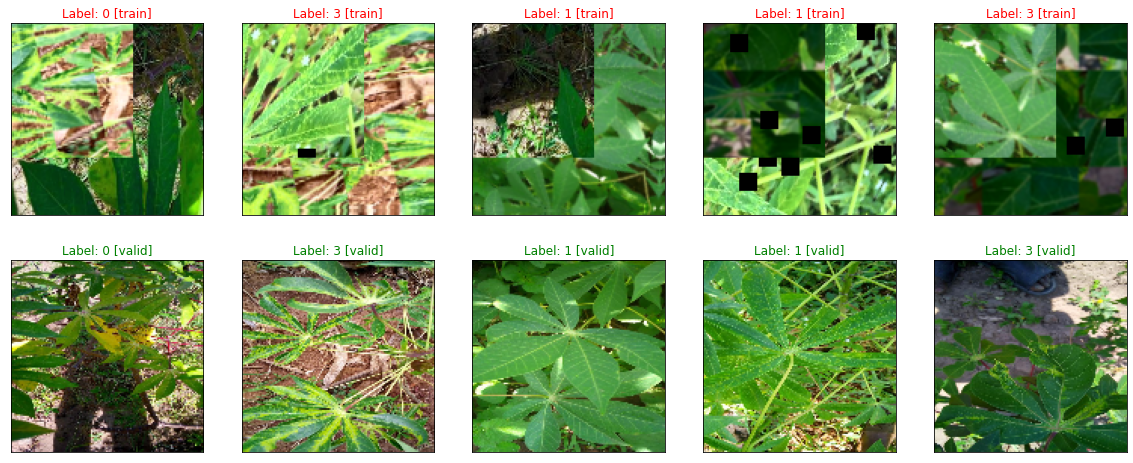

In [18]:
####### EXAMINE SAMPLE BATCH

# sample size
sample = 5

# augmentations
train_augs, test_augs = get_augs(CFG, image_size = 128)

# datasets
train_dataset = LeafData(data      = df.head(sample*2), 
                         directory = CFG['data_path'] + 'train_images/',
                         transform = train_augs,
                         labeled   = True)
test_dataset = LeafData(data       = df.head(sample*2), 
                        directory  = CFG['data_path'] + 'train_images/',
                        transform  = test_augs,
                        labeled    = True)

# data loaders
train_loader = DataLoader(dataset     = train_dataset, 
                          batch_size  = sample, 
                          shuffle       = False, 
                          num_workers = 0)
test_loader = DataLoader(dataset      = test_dataset, 
                         batch_size   = sample, 
                         shuffle        = False, 
                         num_workers  = 0)

# display train images
batch_time = time.time()
for batch_idx, (inputs, labels) in enumerate(train_loader):

    # apply cutmix augmentation
    if CFG['cutmix'][0] > 0:
        mix_decision = 0 #np.random.rand(1)
        if mix_decision < CFG['cutmix'][0]:
            inputs, _ = cutmix_fn(data   = inputs, 
                                  target = labels, 
                                  alpha  = CFG['cutmix'][1])

    # feedback
    inputs_shape = inputs.shape
    load_time    = time.time() - batch_time
    pixel_values = [torch.min(inputs).item(), torch.mean(inputs).item(), torch.max(inputs).item()]

    # examples
    fig = plt.figure(figsize = (20, 8))
    for i in range(sample):
        ax = fig.add_subplot(2, sample, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title('Label: {} [train]'.format(labels[i].numpy()), color = 'red')
    break

# display test images
batch_time = time.time()
for batch_idx, (inputs, labels) in enumerate(test_loader):
            
    # feedback
    print('- batch shape:  {} vs {}'.format(inputs_shape, inputs.shape))
    print('- loading time: {:.4f} vs {:.4f} seconds'.format(load_time, (time.time() - batch_time)))
    print('- pixel values: {:.2f} - {:.2f} - {:.2f} vs {:.2f} - {:.2f} - {:.2f}'.format(
        pixel_values[0], pixel_values[1], pixel_values[2],
        torch.min(inputs).item(), torch.mean(inputs).item(), torch.max(inputs).item()))

    # examples
    for i in range(sample):
        ax = fig.add_subplot(2, sample, sample + i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title('Label: {} [valid]'.format(labels[i].numpy()), color = 'green')
    plt.savefig(CFG['out_path'] + 'fig_sample.png')
    break
    
# clean up
del inputs, labels, batch_idx, train_loader, test_loader, train_dataset, test_dataset, train_augs, test_augs, pixel_values
gc.collect()

# CROSS-VALIDATION

-------------------------------------------------------
FOLD 1/5
-------------------------------------------------------
-- no. images: train - 17117, valid - 4280
- appending 2019 labeled data to train...
-- no. images: train - 22773, valid - 4280
- appending 2019 pseudo-labeled data to train...
-- no. images: train - 26046, valid - 4280
- dealing with bad images from train...
-- no. images: train - 26000, valid - 4280
- size: 512x512, classes: 5, p(augment): 0.5
-------------------------------------------------------
- setting random seed to 13353...
- flipping 168 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.74it/s]


-- epoch 1/12 | lr = 0.000100 | trn_loss = 1.0939 | val_loss = 0.4352 | val_acc = 0.8675 | 15.63 min
- flipping 150 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:07<00:00,  1.97it/s]


-- epoch 2/12 | lr = 0.000097 | trn_loss = 1.0059 | val_loss = 0.3904 | val_acc = 0.8825 | 15.57 min
- flipping 174 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:07<00:00,  1.97it/s]


-- epoch 3/12 | lr = 0.000088 | trn_loss = 0.9936 | val_loss = 0.3896 | val_acc = 0.8797 | 15.49 min
- flipping 171 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:08<00:00,  1.95it/s]


-- epoch 4/12 | lr = 0.000075 | trn_loss = 0.9751 | val_loss = 0.4041 | val_acc = 0.8834 | 15.49 min
- flipping 132 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:07<00:00,  1.97it/s]


-- epoch 5/12 | lr = 0.000059 | trn_loss = 0.9654 | val_loss = 0.3751 | val_acc = 0.8820 | 15.57 min
- flipping 152 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:07<00:00,  1.97it/s]


-- epoch 6/12 | lr = 0.000042 | trn_loss = 0.9552 | val_loss = 0.3719 | val_acc = 0.8930 | 15.52 min
- flipping 165 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:08<00:00,  1.95it/s]


-- epoch 7/12 | lr = 0.000026 | trn_loss = 0.9481 | val_loss = 0.3743 | val_acc = 0.8928 | 15.57 min
- flipping 168 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


-- epoch 8/12 | lr = 0.000013 | trn_loss = 0.9355 | val_loss = 0.3564 | val_acc = 0.8970 | 15.57 min
- flipping 170 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:09<00:00,  1.93it/s]


-- epoch 9/12 | lr = 0.000004 | trn_loss = 0.9382 | val_loss = 0.3579 | val_acc = 0.8974 | 15.46 min
- flipping 165 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:08<00:00,  1.97it/s]


-- epoch 10/12 | lr = 0.000001 | trn_loss = 0.9283 | val_loss = 0.3565 | val_acc = 0.8974 | 15.52 min
- flipping 176 labels...
- size: 512x512, classes: 5, p(augment): 0.5
- freezing deep layers...


100%|██████████| 134/134 [01:09<00:00,  1.94it/s]


-- epoch 11/12 | lr = 0.000097 | trn_loss = 0.9324 | val_loss = 0.3588 | val_acc = 0.8953 | 5.98 min
- flipping 166 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:08<00:00,  1.95it/s]


-- epoch 12/12 | lr = 0.000088 | trn_loss = 0.9336 | val_loss = 0.3581 | val_acc = 0.8951 | 5.88 min
-------------------------------------------------------
Best: acc = 0.8974 (epoch 9), loss = 0.3564 (epoch 8)
-------------------------------------------------------


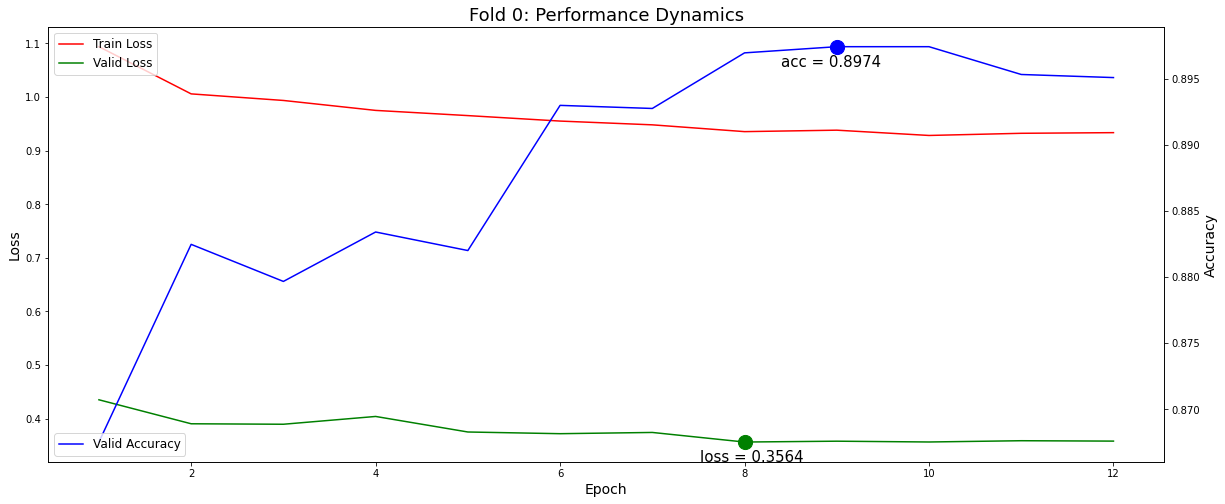

-------------------------------------------------------
FOLD 2/5
-------------------------------------------------------
-- no. images: train - 17117, valid - 4280
- appending 2019 labeled data to train...
-- no. images: train - 22773, valid - 4280
- appending 2019 pseudo-labeled data to train...
-- no. images: train - 26046, valid - 4280
- dealing with bad images from train...
-- no. images: train - 25998, valid - 4280
- size: 512x512, classes: 5, p(augment): 0.5
-------------------------------------------------------
- setting random seed to 13354...
- flipping 161 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:07<00:00,  1.97it/s]


-- epoch 1/12 | lr = 0.000100 | trn_loss = 1.0922 | val_loss = 0.4405 | val_acc = 0.8715 | 15.54 min
- flipping 172 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:07<00:00,  1.97it/s]


-- epoch 2/12 | lr = 0.000097 | trn_loss = 1.0084 | val_loss = 0.3809 | val_acc = 0.8834 | 15.58 min
- flipping 150 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:08<00:00,  1.97it/s]


-- epoch 3/12 | lr = 0.000088 | trn_loss = 0.9862 | val_loss = 0.4000 | val_acc = 0.8780 | 15.63 min
- flipping 148 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:09<00:00,  1.92it/s]


-- epoch 4/12 | lr = 0.000075 | trn_loss = 0.9741 | val_loss = 0.3720 | val_acc = 0.8874 | 15.63 min
- flipping 168 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:08<00:00,  1.97it/s]


-- epoch 5/12 | lr = 0.000059 | trn_loss = 0.9687 | val_loss = 0.3655 | val_acc = 0.8853 | 15.60 min
- flipping 153 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.75it/s]


-- epoch 6/12 | lr = 0.000042 | trn_loss = 0.9554 | val_loss = 0.3692 | val_acc = 0.8918 | 15.92 min
- flipping 180 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:15<00:00,  1.78it/s]


-- epoch 7/12 | lr = 0.000026 | trn_loss = 0.9547 | val_loss = 0.3606 | val_acc = 0.8914 | 16.93 min
- flipping 167 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.76it/s]


-- epoch 8/12 | lr = 0.000013 | trn_loss = 0.9434 | val_loss = 0.3605 | val_acc = 0.8956 | 17.01 min
- flipping 176 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.75it/s]


-- epoch 9/12 | lr = 0.000004 | trn_loss = 0.9358 | val_loss = 0.3562 | val_acc = 0.8946 | 17.05 min
- flipping 165 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.75it/s]


-- epoch 10/12 | lr = 0.000001 | trn_loss = 0.9310 | val_loss = 0.3474 | val_acc = 0.8951 | 17.03 min
- flipping 178 labels...
- size: 512x512, classes: 5, p(augment): 0.5
- freezing deep layers...


100%|██████████| 134/134 [01:17<00:00,  1.74it/s]


-- epoch 11/12 | lr = 0.000097 | trn_loss = 0.9367 | val_loss = 0.3515 | val_acc = 0.8956 | 6.87 min
- flipping 169 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.76it/s]


-- epoch 12/12 | lr = 0.000088 | trn_loss = 0.9431 | val_loss = 0.3442 | val_acc = 0.8942 | 6.81 min
-------------------------------------------------------
Best: acc = 0.8956 (epoch 8), loss = 0.3442 (epoch 12)
-------------------------------------------------------


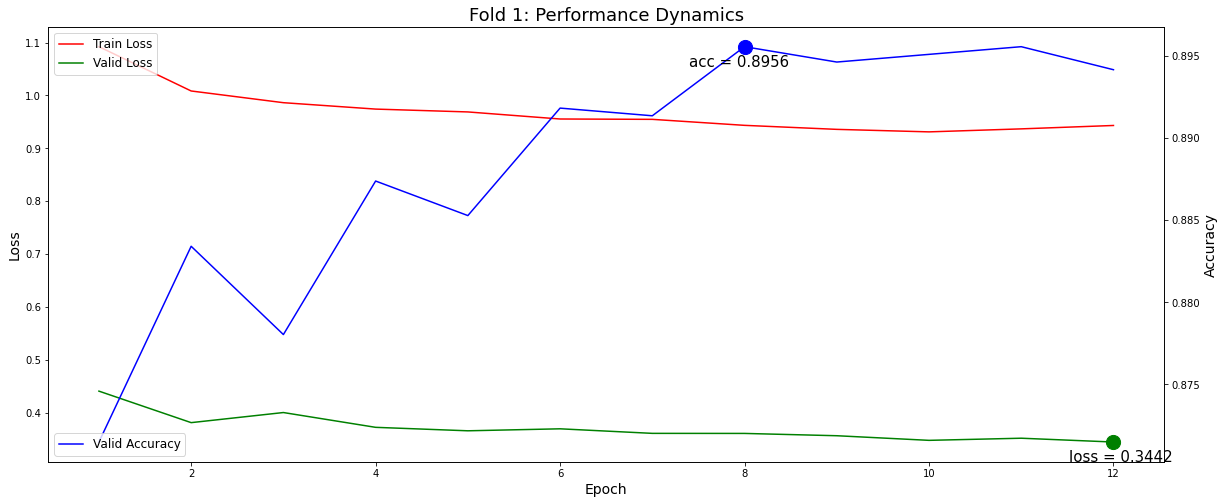

-------------------------------------------------------
FOLD 3/5
-------------------------------------------------------
-- no. images: train - 17118, valid - 4279
- appending 2019 labeled data to train...
-- no. images: train - 22774, valid - 4279
- appending 2019 pseudo-labeled data to train...
-- no. images: train - 26047, valid - 4279
- dealing with bad images from train...
-- no. images: train - 25998, valid - 4279
- size: 512x512, classes: 5, p(augment): 0.5
-------------------------------------------------------
- setting random seed to 13355...
- flipping 167 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:19<00:00,  1.69it/s]


-- epoch 1/12 | lr = 0.000100 | trn_loss = 1.0991 | val_loss = 0.4485 | val_acc = 0.8621 | 17.07 min
- flipping 154 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.76it/s]


-- epoch 2/12 | lr = 0.000097 | trn_loss = 1.0127 | val_loss = 0.4158 | val_acc = 0.8768 | 17.01 min
- flipping 152 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:17<00:00,  1.74it/s]


-- epoch 3/12 | lr = 0.000088 | trn_loss = 0.9892 | val_loss = 0.3910 | val_acc = 0.8836 | 17.06 min
- flipping 154 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.76it/s]


-- epoch 4/12 | lr = 0.000075 | trn_loss = 0.9711 | val_loss = 0.3949 | val_acc = 0.8874 | 17.05 min
- flipping 163 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.75it/s]


-- epoch 5/12 | lr = 0.000059 | trn_loss = 0.9735 | val_loss = 0.3609 | val_acc = 0.8883 | 17.03 min
- flipping 156 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.76it/s]


-- epoch 6/12 | lr = 0.000042 | trn_loss = 0.9540 | val_loss = 0.3792 | val_acc = 0.8855 | 16.98 min
- flipping 150 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.75it/s]


-- epoch 7/12 | lr = 0.000026 | trn_loss = 0.9514 | val_loss = 0.3771 | val_acc = 0.8913 | 17.00 min
- flipping 167 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:15<00:00,  1.76it/s]


-- epoch 8/12 | lr = 0.000013 | trn_loss = 0.9456 | val_loss = 0.3686 | val_acc = 0.8897 | 17.00 min
- flipping 164 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.75it/s]


-- epoch 9/12 | lr = 0.000004 | trn_loss = 0.9381 | val_loss = 0.3585 | val_acc = 0.8906 | 17.04 min
- flipping 181 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.76it/s]


-- epoch 10/12 | lr = 0.000001 | trn_loss = 0.9264 | val_loss = 0.3614 | val_acc = 0.8906 | 17.04 min
- flipping 178 labels...
- size: 512x512, classes: 5, p(augment): 0.5
- freezing deep layers...


100%|██████████| 134/134 [01:16<00:00,  1.75it/s]


-- epoch 11/12 | lr = 0.000097 | trn_loss = 0.9482 | val_loss = 0.3578 | val_acc = 0.8939 | 6.93 min
- flipping 141 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.75it/s]


-- epoch 12/12 | lr = 0.000088 | trn_loss = 0.9452 | val_loss = 0.3489 | val_acc = 0.8918 | 6.77 min
-------------------------------------------------------
Best: acc = 0.8939 (epoch 11), loss = 0.3489 (epoch 12)
-------------------------------------------------------


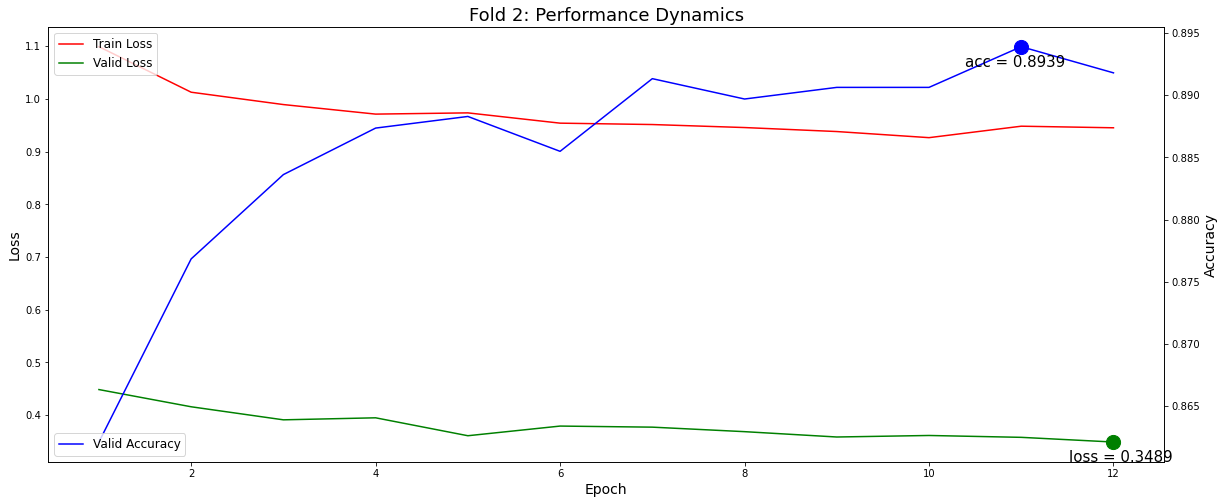

-------------------------------------------------------
FOLD 4/5
-------------------------------------------------------
-- no. images: train - 17118, valid - 4279
- appending 2019 labeled data to train...
-- no. images: train - 22774, valid - 4279
- appending 2019 pseudo-labeled data to train...
-- no. images: train - 26047, valid - 4279
- dealing with bad images from train...
-- no. images: train - 25998, valid - 4279
- size: 512x512, classes: 5, p(augment): 0.5
-------------------------------------------------------
- setting random seed to 13356...
- flipping 147 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.75it/s]


-- epoch 1/12 | lr = 0.000100 | trn_loss = 1.1018 | val_loss = 0.4297 | val_acc = 0.8614 | 17.03 min
- flipping 163 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.76it/s]


-- epoch 2/12 | lr = 0.000097 | trn_loss = 1.0061 | val_loss = 0.4171 | val_acc = 0.8750 | 16.99 min
- flipping 184 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.74it/s]


-- epoch 3/12 | lr = 0.000088 | trn_loss = 0.9906 | val_loss = 0.4075 | val_acc = 0.8876 | 17.04 min
- flipping 169 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.74it/s]


-- epoch 4/12 | lr = 0.000075 | trn_loss = 0.9799 | val_loss = 0.3567 | val_acc = 0.8892 | 17.07 min
- flipping 170 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.76it/s]


-- epoch 5/12 | lr = 0.000059 | trn_loss = 0.9640 | val_loss = 0.3589 | val_acc = 0.8932 | 17.00 min
- flipping 148 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:17<00:00,  1.73it/s]


-- epoch 6/12 | lr = 0.000042 | trn_loss = 0.9567 | val_loss = 0.3644 | val_acc = 0.8941 | 17.03 min
- flipping 143 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.76it/s]


-- epoch 7/12 | lr = 0.000026 | trn_loss = 0.9480 | val_loss = 0.3504 | val_acc = 0.8946 | 17.03 min
- flipping 161 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.75it/s]


-- epoch 8/12 | lr = 0.000013 | trn_loss = 0.9455 | val_loss = 0.3490 | val_acc = 0.8946 | 17.03 min
- flipping 156 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.76it/s]


-- epoch 9/12 | lr = 0.000004 | trn_loss = 0.9379 | val_loss = 0.3491 | val_acc = 0.8953 | 17.01 min
- flipping 173 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.76it/s]


-- epoch 10/12 | lr = 0.000001 | trn_loss = 0.9310 | val_loss = 0.3465 | val_acc = 0.8962 | 17.00 min
- flipping 190 labels...
- size: 512x512, classes: 5, p(augment): 0.5
- freezing deep layers...


100%|██████████| 134/134 [01:16<00:00,  1.75it/s]


-- epoch 11/12 | lr = 0.000097 | trn_loss = 0.9423 | val_loss = 0.3362 | val_acc = 0.8958 | 6.91 min
- flipping 166 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:15<00:00,  1.77it/s]


-- epoch 12/12 | lr = 0.000088 | trn_loss = 0.9384 | val_loss = 0.3412 | val_acc = 0.8951 | 6.76 min
-------------------------------------------------------
Best: acc = 0.8962 (epoch 10), loss = 0.3362 (epoch 11)
-------------------------------------------------------


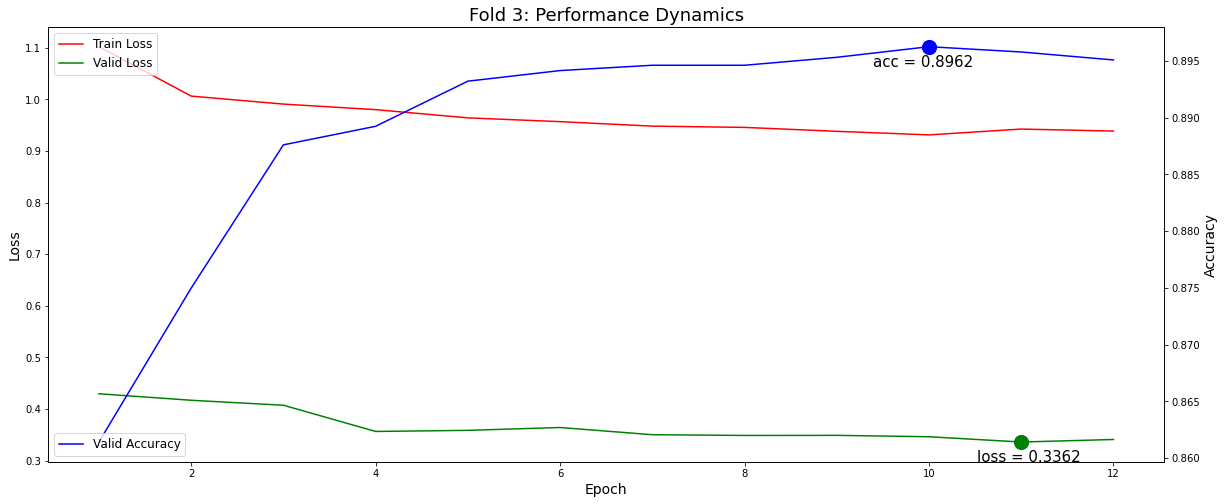

-------------------------------------------------------
FOLD 5/5
-------------------------------------------------------
-- no. images: train - 17118, valid - 4279
- appending 2019 labeled data to train...
-- no. images: train - 22774, valid - 4279
- appending 2019 pseudo-labeled data to train...
-- no. images: train - 26047, valid - 4279
- dealing with bad images from train...
-- no. images: train - 26000, valid - 4279
- size: 512x512, classes: 5, p(augment): 0.5
-------------------------------------------------------
- setting random seed to 13357...
- flipping 154 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:19<00:00,  1.70it/s]


-- epoch 1/12 | lr = 0.000100 | trn_loss = 1.1249 | val_loss = 0.7299 | val_acc = 0.8497 | 17.01 min
- flipping 171 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.74it/s]


-- epoch 2/12 | lr = 0.000097 | trn_loss = 1.0394 | val_loss = 0.7466 | val_acc = 0.8694 | 16.99 min
- flipping 166 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.76it/s]


-- epoch 3/12 | lr = 0.000088 | trn_loss = 1.0205 | val_loss = 0.9583 | val_acc = 0.8663 | 16.97 min
- flipping 147 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.76it/s]


-- epoch 4/12 | lr = 0.000075 | trn_loss = 1.0147 | val_loss = 0.5603 | val_acc = 0.8834 | 16.98 min
- flipping 182 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.76it/s]


-- epoch 5/12 | lr = 0.000059 | trn_loss = 0.9982 | val_loss = 0.4650 | val_acc = 0.8850 | 17.00 min
- flipping 172 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:15<00:00,  1.76it/s]


-- epoch 6/12 | lr = 0.000042 | trn_loss = 0.9949 | val_loss = 0.4057 | val_acc = 0.8916 | 16.98 min
- flipping 167 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.76it/s]


-- epoch 7/12 | lr = 0.000026 | trn_loss = 0.9805 | val_loss = 0.4348 | val_acc = 0.8916 | 16.97 min
- flipping 166 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:17<00:00,  1.74it/s]


-- epoch 8/12 | lr = 0.000013 | trn_loss = 0.9759 | val_loss = 0.4864 | val_acc = 0.8930 | 17.02 min
- flipping 153 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.76it/s]


-- epoch 9/12 | lr = 0.000004 | trn_loss = 0.9712 | val_loss = 0.3890 | val_acc = 0.8983 | 17.00 min
- flipping 183 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:16<00:00,  1.76it/s]


-- epoch 10/12 | lr = 0.000001 | trn_loss = 0.9711 | val_loss = 0.3877 | val_acc = 0.8990 | 16.99 min
- flipping 185 labels...
- size: 512x512, classes: 5, p(augment): 0.5
- freezing deep layers...


100%|██████████| 134/134 [01:16<00:00,  1.75it/s]


-- epoch 11/12 | lr = 0.000097 | trn_loss = 0.9661 | val_loss = 0.4101 | val_acc = 0.8965 | 6.86 min
- flipping 156 labels...
- size: 512x512, classes: 5, p(augment): 0.5


100%|██████████| 134/134 [01:15<00:00,  1.76it/s]


-- epoch 12/12 | lr = 0.000088 | trn_loss = 0.9693 | val_loss = 0.4058 | val_acc = 0.8969 | 6.76 min
-------------------------------------------------------
Best: acc = 0.8990 (epoch 10), loss = 0.3877 (epoch 10)
-------------------------------------------------------


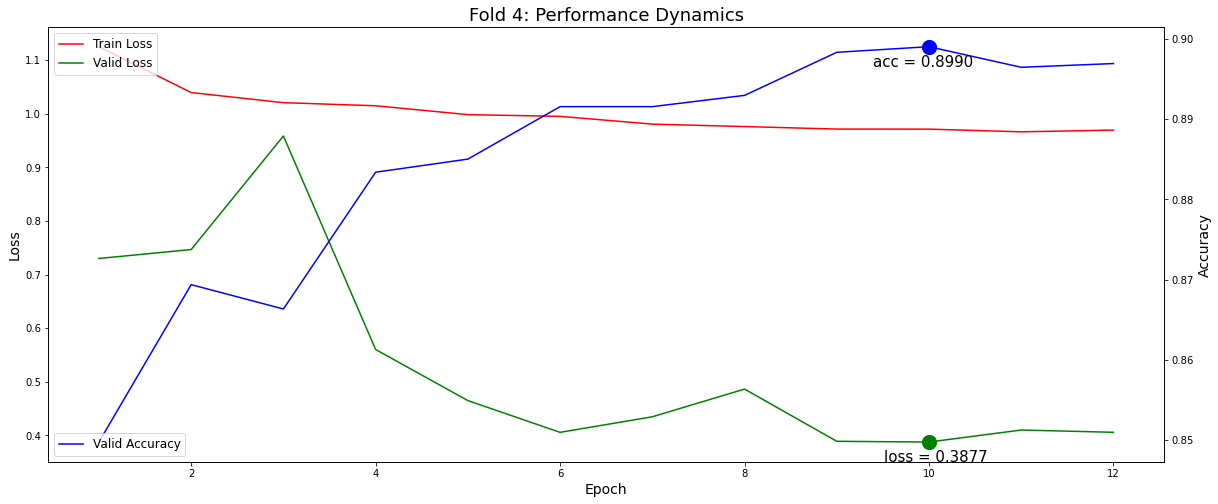


Finished in 897.17 minutes


In [32]:
####### CROSS-VALIDATION LOOP

##### INITIALIZATION

# timer
cv_start = time.time()

# clear memory
import gc
gc.collect()

# placeholders
oof  = None
perf = pd.DataFrame(columns = ['fold', 'epoch', 'trn_loss', 'val_loss', 'val_acc'])

# amp settings
amp_autocast = suppress
if CFG['use_amp']:
    amp_autocast = torch.cuda.amp.autocast
    scaler       = torch.cuda.amp.GradScaler()       

# adjust epochs if needed
if CFG['debug']:
    CFG['num_epochs'] = 2
    CFG['num_folds']  = 2
    CFG['fine_tune']   = 1
    
    
##### CROSS-VALIDAION

for fold in range(CFG['num_folds']):
    
    ### PERFORM MODELING
    
    # feedback
    print('-' * 55)
    print('FOLD {:d}/{:d}'.format(fold + 1, CFG['num_folds']))    
    print('-' * 55) 
    
    # prepare data
    trn_loader, val_loader, df_trn, df_val = get_data(df, fold, CFG,
                                                      df_2019    = df_2019 if CFG['data_2019'] else None,
                                                      df_pl      = df_pl if CFG['data_pl'] else None,
                                                      df_ext     = df_ext if CFG['data_ext'] else None,
                                                      df_no      = df_no,
                                                      list_dupl  = list_dupl if CFG['drop_dupl'] else [],
                                                      list_noise = list_noise if CFG['drop_noise'] else []) 

    # training and inference
    if CFG['device'] != 'TPU':
        trn_losses, val_losses, val_metrics, val_preds_best = run_fold(fold       = fold, 
                                                                       trn_loader = trn_loader, 
                                                                       val_loader = val_loader, 
                                                                       df         = df,
                                                                       df_2019    = df_2019 if CFG['data_2019'] else None,
                                                                       df_pl      = df_pl if CFG['data_pl'] else None,
                                                                       df_ext     = df_ext if CFG['data_ext'] else None,
                                                                       df_no      = df_no,
                                                                       list_dupl  = list_dupl if CFG['drop_dupl'] else [],
                                                                       list_noise = list_noise if CFG['drop_noise'] else [],
                                                                       df_trn     = df_trn, 
                                                                       df_val     = df_val, 
                                                                       CFG        = CFG, 
                                                                       device     = device)
    else:
        def _mp_fn(rank, CFG):
            torch.set_default_tensor_type('torch.FloatTensor')
            device = xm.xla_device()
            trn_losses, val_losses, val_metrics, val_preds_best = run_fold(fold       = fold, 
                                                                            trn_loader = trn_loader, 
                                                                            val_loader = val_loader, 
                                                                            df         = df,
                                                                            df_2019    = df_2019 if CFG['data_2019'] else None,
                                                                            df_pl      = df_pl if CFG['data_pl'] else None,
                                                                            df_ext     = df_ext if CFG['data_ext'] else None,
                                                                            df_no      = df_no,
                                                                            list_dupl  = list_dupl if CFG['drop_dupl'] else [],
                                                                            list_noise = list_noise if CFG['drop_noise'] else [],
                                                                            df_trn     = df_trn, 
                                                                            df_val     = df_val, 
                                                                            CFG        = CFG, 
                                                                            device     = device)
            if rank == 0:
                np.save('trn_losses.npy',     np.array(trn_losses))
                np.save('val_losses.npy',     np.array(val_losses))
                np.save('val_metrics.npy',    np.array(val_metrics))
                np.save('val_preds_best.npy', val_preds_best)
        xmp.spawn(_mp_fn, args = (CFG, ), nprocs = CFG['num_workers'], start_method = 'fork')
        trn_losses          = np.load('trn_losses.npy')
        val_losses          = np.load('val_losses.npy')
        val_metrics         = np.load('val_metrics.npy')
        val_preds_best      = np.load('val_preds_best.npy')


    ### SAVE RESULTS
    
    # performance table
    perf = pd.concat([perf, 
                      pd.DataFrame({'fold':     [fold] * (CFG['num_epochs'] + CFG['fine_tune']), 
                                    'epoch':    list(range(CFG['num_epochs'] + CFG['fine_tune'])),
                                    'trn_loss': trn_losses,
                                    'val_loss': val_losses,
                                    'val_acc':  val_metrics})],
                    axis = 0)
    perf.to_csv(CFG['out_path'] + 'tab_performance.csv', index = False)
            
    # export OOF predictions
    val_preds_df = pd.DataFrame(val_preds_best, columns = ['c' + str(class_idx) for class_idx in range(CFG['num_classes'])])
    val_preds_df = pd.concat([df_val, val_preds_df], axis = 1)
    oof = pd.concat([oof, val_preds_df], axis = 0).reset_index(drop = True)
    oof.to_csv(CFG['out_path'] + 'oof.csv', index = False)


    ### DISPLAY FEEDBACK

    # feedback
    print('-' * 55)
    print('Best: acc = {:.4f} (epoch {}), loss = {:.4f} (epoch {})'.format(
        np.max(val_metrics), np.argmax(val_metrics) + 1, np.min(val_losses), np.argmin(val_losses) + 1))
    print('-' * 55)

    # plot loss dynamics
    plot_results(trn_losses, val_losses, val_metrics, fold, CFG)


##### FEEDBACK

print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

# EVALUATION

In [33]:
####### CHECK OOF PERFORMANCE

# compute accuracy
oof['pred'] = np.argmax(oof[['c' + str(class_idx) for class_idx in range(CFG['num_classes'])]].values, axis = 1)
oof_acc     = (oof['pred'] == oof['label']).sum() / len(oof)
oof_loss    = perf.groupby('fold')['val_loss'].agg('min').mean()

# print results
print('- OOF acc  = {:.4f}'.format(oof_acc))
print('- OOF loss = {:.4f}'.format(oof_loss))

# save results
res = pd.DataFrame({'fold':     ['oof',], 
                    'epoch':    ['best'],
                    'trn_loss': [np.nan],
                    'val_loss': [oof_loss],
                    'val_acc':  [oof_acc]})
perf = pd.concat([perf, res], axis = 0)
perf.to_csv(CFG['out_path'] + 'tab_performance.csv', index = False)

- OOF acc  = 0.8964
- OOF loss = 0.3547


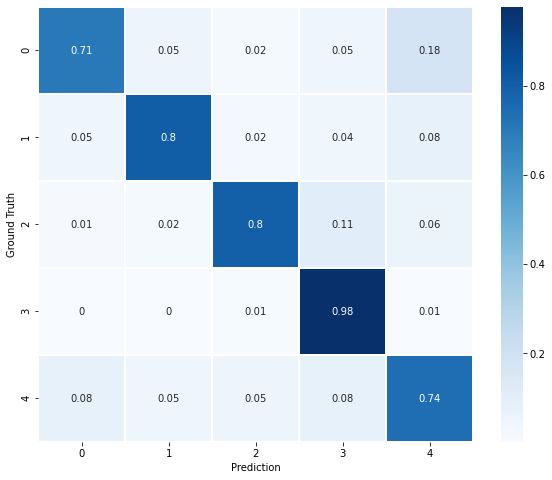

In [34]:
####### CONFUSION MATRIX

# construct confusion matrx
cm    = confusion_matrix(y_true = oof['label'], y_pred = oof['pred'], normalize = 'true')
annot = np.around(cm, 2)

# plot matrix
fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(cm, cmap = 'Blues', annot = annot, lw = 0.5)
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth')
ax.set_aspect('equal')
    
# export plot
plt.savefig(CFG['out_path'] + 'fig_confusion.png')

In [35]:
####### PREDICTIONS WITH GRADCAM SETTINGS

if not CFG['attention']:

    # images per classs
    sample = 4

    # get augmentations
    _, sample_augs = get_augs(CFG, image_size = 512)

    # get model with weights
    model, _, _ = get_model(CFG, device)
    for name, child in model.named_children():
        for param in child.parameters():
            param.requires_grad = True
    model.load_state_dict(torch.load(CFG['out_path'] + 'weights_fold{}.pth'.format(fold), map_location = device))

    # feature and target modules
    if 'efficient' in CFG['backbone']:
        feature_block = model.blocks
        target_layers = ['6']
    else:
        feature_block = model.layer4
        target_layers = ['2']

    # gradcam
    grad_cam = GradCam(model              = model, 
                       feature_module     = feature_block,
                       target_layer_names = target_layers, 
                       use_cuda           = True)

    # prepare dataframes
    oof['correct']    = oof['pred'] == oof['label']
    oof['confidence'] = np.max(oof[['c' + str(class_idx) for class_idx in range(CFG['num_classes'])]].values, axis = 1)
    oof               = oof.sort_values(['label', 'confidence'], ascending = True)
    rights = oof.loc[oof['correct'] == True].groupby('label').tail(sample).reset_index(drop  = True)
    wrongs = oof.loc[oof['correct'] == False].groupby('label').tail(sample).reset_index(drop = True)

    # datasets
    right_dataset = LeafData(data      = rights, 
                             directory = CFG['data_path'] + 'train_images/',
                             transform = sample_augs,
                             labeled   = True)
    wrong_dataset = LeafData(data      = wrongs,  
                             directory = CFG['data_path'] + 'train_images/',
                             transform = sample_augs,
                             labeled   = True)
    # data loaders
    right_loader = DataLoader(dataset     = right_dataset, 
                              batch_size  = sample * CFG['num_classes'], 
                              shuffle       = False, 
                              num_workers = 0,
                              pin_memory  = True)
    wrong_loader = DataLoader(dataset     = wrong_dataset, 
                              batch_size  = sample * CFG['num_classes'],
                              shuffle       = False, 
                              num_workers = 0,
                              pin_memory  = True)

In [36]:
####### EXAMINE WRONG PREDICTIONS 

if not CFG['attention']:

    # display and save image grid
    fig = plt.figure(figsize = (20, 20))
    for batch_idx, (inputs, labels) in enumerate(wrong_loader):
        for i in range(inputs.shape[0]):

            # compute gradcam
            grayscale_cam = grad_cam(inputs[i].unsqueeze(0), None)
            cam = show_cam_on_image(inputs[i].numpy().transpose(1, 2, 0), grayscale_cam)

            # plot results
            ax = fig.add_subplot(CFG['num_classes'], sample, i + 1, xticks = [], yticks = [])     
            plt.imshow(cam)
            ax.set_title('{} [pred = {}, p = {:.2f}]'.format(
                labels[i].numpy(), wrongs.iloc[i]['pred'], wrongs.iloc[i]['confidence']), color = 'red')

    # export
    plt.savefig(CFG['out_path'] + 'fig_preds_wrong.png')

In [38]:
####### EXPORT CONFIGURATION

# store performance values
CFG['time_min'] = (time.time() - cv_start) / 60
CFG['oof_acc']  = oof_acc
CFG['oof_loss'] = oof_loss

# save DF
params = pd.DataFrame.from_dict(CFG, orient = 'index', columns = ['value'])
params.to_csv(CFG['out_path'] + 'tab_configuration.csv', index = True)